<a href="https://colab.research.google.com/github/sharan8/ML-Tumour-Classification/blob/master/Breast_Cancer_Tumour_Tissue_Classification_A_Deep_Learning_CNN_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect to google drive

In [0]:
# connecting to google drive
from google.colab import drive 
drive.mount('/mntDrive') 

Drive already mounted at /mntDrive; to attempt to forcibly remount, call drive.mount("/mntDrive", force_remount=True).


# Import all the required Python libraries

In [0]:
# to keep track of time taken
import time

# for naming files with time stamp
import datetime

# for collecting the data from google drive
import os
import threading
import queue

# for preprocessing the data
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau, TensorBoard
from keras.utils.np_utils import to_categorical
import keras.preprocessing.image as image
import numpy as np
import random

# import statements for building models
from keras import layers
from keras import models
from keras import optimizers
from keras.applications import VGG16
from keras.models import load_model

# for visualising the results
import matplotlib.pyplot as plt
import json
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# garbage collector
import gc

Using TensorFlow backend.


# All the constant values are placed here

In [0]:
# timestamp meant for the file formatting
def get_file_timestamp():
  """Returns string of the format YYMMDD_HHMM
  """
  now = datetime.datetime.now()
  time_stamp = "{:02}{:02}{:02}_{:02}{:02}{:02}".format(
      now.year, now.month, now.day, now.hour, now.minute, now.second)
  return time_stamp
time_stamp = get_file_timestamp()
print("time_stamp = {}".format(time_stamp))


time_stamp = 20191114_000328


In [0]:
# constants
TRAIN_BATCH_SIZE = 8
VALIDATION_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
TARGET_HEIGHT = 300
TARGET_WIDTH = 300
TRAIN_EPOCHS = 30
IS_MALIGNANT_AND_BENIGN_SAME_SIZE = True

FREEZE_LAYER = "block5_conv1"

BENIGN_DIR = '/mntDrive/My Drive/ML Project/CompleteDataset/breast/benign/SOB'
MALIGNANT_DIR= ('/mntDrive/My Drive/ML Project/CompleteDataset/breast/'
                'malignant/SOB')
HISTORY_DIR = '/mntDrive/My Drive/ML Project/final_code/saved/' + time_stamp
LOAD_WEIGHT_FROM_DIRECTORY = True

In [0]:
# create history directory
if not os.path.exists(HISTORY_DIR):
    os.makedirs(HISTORY_DIR)

# Garbage collector

In [0]:
gc.enable()

Timer class for measuring time taken for different parts of the code

In [0]:
class my_timer:
  def __init__(self):
    self.start_time = time.time()
  def elapsed(self):
    time_elapsed = time.time() - self.start_time
    minute = int(time_elapsed / 60)
    second = int(time_elapsed % 60)
    duration_str = "{} minutes {} seconds".format(minute, second)
    return duration_str
timer = my_timer()

# Functions for collecting image paths

In [0]:
# get all paths within a directory
def get_image_path_list_from_dir(dir):
  """ Takes a directory, returns all image path from this directory
  # Arguments
    dir: string, path to the source directory that  contains the image. Only
      members of this dir that has '.png' extension would be considered. Does 
      not handle images that are nested within another directory within dir.

  # Returns
    A list containing the image paths
  """
  # a list of image's names, excluding those that does not contain '.png'
  image_filenames = [fname for fname in os.listdir(dir) if '.png' == fname[-4:]]

  # a list of the full image path
  image_paths = [os.path.join(dir, fname) for fname in image_filenames]

  return image_paths

In [0]:
# get the paths to all the directories within one directory
def get_paths_to_nested_dir(dir):
  """ Takes a directory name, returns the path to directories within

    dir: string, path to the source directory that contains directories

  # Returns
    list of string for the paths of nest directories
  """
  inner_dir_paths = []
  for inner_dir in os.listdir(dir):
    full_path = os.path.join(dir, inner_dir)
    if os.path.isdir(full_path):
      inner_dir_paths.append(full_path)

  return inner_dir_paths

In [0]:
# get all the image paths for one person
def get_image_path_list_for_person(dir, mag = [40, 100, 200, 400]):
  """ Takes directory path for a person, return images from this directory
  # Arguments
    dir: the main directory path representing one patient 
    mag: a list of magnification to obtain the image

  # Returns
    A list containing the images path
  """
  mag_paths = get_magnification_path_list(dir, mag)
  image_paths = []
  for mag_path in mag_paths:
    curr_image_paths = get_image_path_list_from_dir(mag_path)
    image_paths = image_paths + curr_image_paths
  return image_paths

In [0]:
# get the path to all the directories that name comform to the 
# magnification specified by 'mag' array
def get_magnification_path_list(dir, mag = [40, 100, 200, 400]):
  """ Takes a directory name, returns the path for the different magnifications
  # Arguments
    dir: string, path to the source directory that have different magnification
      directories.

    mag: list of integers. Valid integers are 40, 100, 200 and 400

  # Returns
    list of string for the paths for the magnification directories
  """
  magnification_paths = []
  for fname in os.listdir(dir):
    mag_strs = ['40', '100', '200', '400']
    if fname[:-1] in mag_strs:
      path = os.path.join(dir, fname)
      magnification_paths.append(path)

  return magnification_paths

In [0]:
# get the all the paths within a malignanct (benign vs malignant) directory
def get_image_path_by_person_from_malignancy_dir(dir, mag = [40, 100, 200, 400]):
  """ Takes directory path that represents malignancy (benign / malignant) and
   return the images from this directory
  # Arguments
    dir: the main directory path representing one patient 
    mag: a list of magnification to obtain the image

  # Returns
    A list of list of image paths
  """
  tumour_type_paths = get_paths_to_nested_dir(dir)
  person_paths = []

  for tumour_type_path in tumour_type_paths:
    curr_person_paths = get_paths_to_nested_dir(tumour_type_path)
    person_paths = person_paths + curr_person_paths
  
  image_paths = []
  person_count = 0
  for person_path in person_paths:
    curr_image_paths = get_image_path_list_for_person(person_path, mag)
    image_paths.append(curr_image_paths)
    person_count += 1

  return image_paths

# Functions for collecting the images base on path

In [0]:
# Given an image path, returns a rank3 numpy representing the image
def read_image(image_path, target_height, target_width):
  img = image.load_img(image_path, target_size=(target_height, target_width))
  img_array = image.img_to_array(img)
  return img_array

In [0]:
# given a list of image path, put an array of rank 3 numpy representing the
# image inside the imgs_syn_queue (a thread safe queue)
def multithread_images_from_image_paths(image_paths, imgs_syn_queue,
                                        target_height=225, target_width=225):
  inner_timer = my_timer()

  imgs = [] # store a list of image represented as numpy array

  for image_path in image_paths:
    img_array = read_image(image_path, target_height, target_width)
    imgs.append(img_array)

  imgs_syn_queue.put(imgs)
  # print('time taken to collect {} images = {}\n'.
  #       format(len(imgs), inner_timer.elapsed()), end='')

In [0]:
# given a list of list of image paths, returns a list of list of 
# rank 3 numpy representing the images
def multithread_images_by_person_from_paths(list_of_image_paths,
                                          target_height=225, target_width=225):
  # a synchronised queue where each member is a list of images (in DIL format)
  images_queue = queue.Queue()
  threads = []
  
  for image_paths in list_of_image_paths:
    # commented out the non multithreaded approach
    # multithread_images_from_image_paths(image_paths, images_queue,
    #                                     target_height, target_width)
    thread = threading.Thread(target=multithread_images_from_image_paths,
                              args=(image_paths, images_queue,
                                    target_height, target_width))
    thread.start()
    threads.append(thread)

  for i in range(len(threads)):
    threads[i].join()

  images_by_person = []
  while not images_queue.empty():
    images_by_person.append(images_queue.get())

  return images_by_person

# Collect the images

Collect the image paths

In [0]:
benign_paths = get_image_path_by_person_from_malignancy_dir(BENIGN_DIR)
print("time after collecting benign_paths =", timer.elapsed())
malignant_paths = get_image_path_by_person_from_malignancy_dir(MALIGNANT_DIR)
print("time after collecting malignant_paths =", timer.elapsed())

time after collecting benign_paths = 0 minutes 0 seconds
time after collecting malignant_paths = 0 minutes 0 seconds


Collect the actual images

In [0]:
benign_images = multithread_images_by_person_from_paths(benign_paths,
                                                        TARGET_HEIGHT,
                                                        TARGET_WIDTH)
print("time after collecting benign_images", timer.elapsed())
malignant_images = multithread_images_by_person_from_paths(malignant_paths,
                                                          TARGET_HEIGHT,
                                                          TARGET_WIDTH)
print("time after collecting malignant_images", timer.elapsed())

time after collecting benign_images 0 minutes 20 seconds
time after collecting malignant_images 1 minutes 1 seconds


# Prepare the dataset

Functions to find the number of images in each dataset (training, validation and test)

In [0]:
# count the number of image in each dataset base on split ratio
def get_split_numbers (person_images_list, train_ratio = 0.5, val_ratio = 0.25, 
                       test_ratio = 0.25):
  total_count = 0
  # count the total numer of images
  for person_images in person_images_list:
    total_count += len(person_images)
  est_train_size = int(total_count * train_ratio)
  est_val_size = int(total_count * val_ratio)

  curr_count = 0
  train_size = -1
  val_size = -1
  test_size = -1
  for person_images in person_images_list:
    next_count = curr_count + len(person_images)
    if next_count < est_train_size:
      curr_count = next_count
      continue

    if next_count == est_train_size:
      curr_count = next_count
      train_size = curr_count
      continue
    
    # curr_count + len(person_images) > est_train_size here
    if train_size == -1:
      train_size = curr_count
    
    if next_count - train_size < est_val_size:
      curr_count = next_count
      continue
    
    val_size = next_count - train_size
    # if validation size more than 10% larger than expected, use the smaller value
    if val_size > est_val_size * 1.1:
      val_size = curr_count - train_size

    break

  test_size = total_count - val_size - train_size

  return train_size, val_size, test_size

In [0]:
# split the images into training, validation and test
def split_images(person_images_list, train_size, val_size, test_size):
  all_images = []
  all_size = train_size + val_size + test_size
  for images in person_images_list:
    prev_size = len(all_images)
    all_images = all_images + images
    curr_size = len(all_images)


    if curr_size > train_size and prev_size < train_size:
      # make sure that images from the same person does not appear in both
      # train_set and validation set
      all_images = all_images[:train_size]
      continue
    if curr_size > train_size + val_size and prev_size < train_size + val_size:
      # make sure that the images from the same person does not appear in both
      # validation set and test set
      all_images = all_images[:train_size + val_size]
      continue


  train_set = all_images[:train_size]
  val_set = all_images[train_size : train_size + val_size]
  test_set = all_images[train_size + val_size : all_size]
  return train_set, val_set, test_set


Split the images into training, validation and test

In [0]:
# split the images into training, validation and test
benign_train_size, benign_val_size, benign_test_size = get_split_numbers (
                                                            benign_images)
print("get split count for benign after", timer.elapsed())

# split the dataset for benign images
print("starting to split benign image at", timer.elapsed())
benign_train, benign_val, benign_test = split_images(benign_images,
                        benign_train_size, benign_val_size, benign_test_size)

print("done splitting benign image at", timer.elapsed())

print("starting to split malignant image at", timer.elapsed())

malignant_train_size, malignant_val_size, malignant_test_size = (
    get_split_numbers (malignant_images))

malignant_train, malignant_val, malignant_test = split_images(malignant_images, 
                 malignant_train_size, malignant_val_size, malignant_test_size)
print("complete splitting malignant image at", timer.elapsed())

get split count for benign after 1 minutes 1 seconds
starting to split benign image at 1 minutes 1 seconds
done splitting benign image at 1 minutes 1 seconds
starting to split malignant image at 1 minutes 1 seconds
complete splitting malignant image at 1 minutes 1 seconds


In [0]:
# reducing the size of malignant dataset
def reduce_dataset_randomly(dataset, target_value):
  random.shuffle(dataset)
  del dataset[:target_value]

if IS_MALIGNANT_AND_BENIGN_SAME_SIZE:
  print("reducing size of malignant data at", timer.elapsed())
  reduce_dataset_randomly(malignant_train, benign_train_size)
  reduce_dataset_randomly(malignant_val, benign_val_size)
  reduce_dataset_randomly(malignant_test, benign_test_size)
  print("done reducing size of malignant data at", timer.elapsed())

reducing size of malignant data at 1 minutes 1 seconds
done reducing size of malignant data at 1 minutes 1 seconds


# Create the x dataset

In [0]:
# join the benign and malignant arrays into rank4 numpy arrays
print("staring to create train_x at", timer.elapsed())
train_x = np.array(benign_train + malignant_train)
benign_train_size = len(benign_train)
malignant_train_size = len(malignant_train)
del benign_train
del malignant_train
print("done creating train_x at", timer.elapsed())

val_x = np.array(benign_val + malignant_val)
benign_val_size = len(benign_val)
malignant_val_size = len(malignant_val)
del benign_val
del malignant_val
print("done creating val_x at", timer.elapsed())

test_x = np.array(benign_test + malignant_test)
benign_test_size = len(benign_test)
malignant_test_size = len(malignant_test)
del benign_test
del malignant_test
print("done creating test_x at", timer.elapsed())

staring to create train_x at 1 minutes 1 seconds
done creating train_x at 1 minutes 3 seconds
done creating val_x at 1 minutes 6 seconds
done creating test_x at 1 minutes 9 seconds


Create the y dataset

In [0]:
# create the y datasets
def get_y_numpy(zero_size, one_size):
  zeros = np.zeros(zero_size)
  ones = np.ones(one_size)
  result = np.concatenate((zeros, ones), axis=0)
  result = to_categorical(result, num_classes=2)
  return result


print("starting to create the y numpy at", timer.elapsed())
train_y = get_y_numpy(benign_train_size, malignant_train_size)
val_y = get_y_numpy(benign_val_size, malignant_val_size)
test_y = get_y_numpy(benign_test_size, malignant_test_size)
print("done creating the y numpy at", timer.elapsed())

starting to create the y numpy at 1 minutes 9 seconds
done creating the y numpy at 1 minutes 9 seconds


In [0]:
print("train_x.shape =", train_x.shape)
print("val_x.shape =", val_x.shape)
print("test_x.shape = ", test_x.shape)

print("train_y.shape =", train_y.shape)
print("val_y.shape =", val_y.shape)
print("test_y.shape =", test_y.shape)

train_x.shape = (2659, 300, 300, 3)
val_x.shape = (1393, 300, 300, 3)
test_x.shape =  (1377, 300, 300, 3)
train_y.shape = (2659, 2)
val_y.shape = (1393, 2)
test_y.shape = (1377, 2)


Creating the dataset generator

In [0]:
# initialise the generators
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
print("starting to initalise the generators at", timer.elapsed())
# create the test generator
test_datagen = ImageDataGenerator()
# create the train_generator
train_generator = train_datagen.flow(train_x, train_y, 
                                     batch_size=TRAIN_BATCH_SIZE)

validation_generator = test_datagen.flow(val_x, val_y,
                                         batch_size=VALIDATION_BATCH_SIZE)
print("done initialising the generators at", timer.elapsed())

starting to initalise the generators at 1 minutes 9 seconds
done initialising the generators at 1 minutes 9 seconds


# Build the model

In [0]:
equal_str = 'equal' if IS_MALIGNANT_AND_BENIGN_SAME_SIZE else 'unequal'
local_hdf5_fname = 'yo_model_hdf5_{}_{}_{}.hdf5'.format(TARGET_WIDTH, equal_str, 
                                                   time_stamp)

learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                verbose=1,factor=0.2, min_lr=1e-7)

checkpoint = ModelCheckpoint(local_hdf5_fname, monitor='val_acc', verbose=1,
                            save_best_only=True, mode='max')


In [0]:
# building the model base on VGG16
print("starting to build the model at", timer.elapsed())
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3))
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))
conv_base.trainable=False
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
print("done compiling the model at", timer.elapsed())

starting to build the model at 1 minutes 9 seconds












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
done compiling the model at 1 minutes 10 seconds


 # Run the model

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               10617088  
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 25,332,290
Trainable params: 10,617,602
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
# initialise and train the model
model_timer = my_timer()
print("starting to train the model at", timer.elapsed())
history = model.fit_generator(
    train_generator,
    steps_per_epoch=(len(train_x) // TRAIN_BATCH_SIZE),
    epochs=TRAIN_EPOCHS,
    validation_data=validation_generator,
    validation_steps=(len(val_x) // VALIDATION_BATCH_SIZE),
    callbacks=[learn_control, checkpoint]
)
print("done training the model at", timer.elapsed())
print("first round of training done in", model_timer.elapsed())

starting to train the model at 1 minutes 10 seconds


Epoch 1/30
332/332 [==============================] - 59s 179ms/step - loss: 1.5385 - acc: 0.7215 - val_loss: 1.7383 - val_acc: 0.5999

Epoch 00001: val_acc improved from -inf to 0.59986, saving model to yo_model_hdf5_300_equal_20191114_000328.hdf5
Epoch 2/30
332/332 [==============================] - 58s 174ms/step - loss: 0.8972 - acc: 0.7722 - val_loss: 1.4744 - val_acc: 0.6000

Epoch 00002: val_acc improved from 0.59986 to 0.60000, saving model to yo_model_hdf5_300_equal_20191114_000328.hdf5
Epoch 3/30
332/332 [==============================] - 58s 175ms/step - loss: 0.6315 - acc: 0.7999 - val_loss: 1.2155 - val_acc: 0.6249

Epoch 00003: val_acc improved from 0.60000 to 0.62491, saving model to yo_model_hdf5_300_equal_20191114_000328.hdf5
Epoch 4/30
332/332 [==============================] - 57s 172ms/step - loss: 0.5599 - acc: 0.8143 - val_loss: 1.1051 - val_acc: 0.6437

Epoch 00004: val_acc improved from 0.62491 to 0.64368, sa

# Save all the related values into google drive

In [0]:
# save the history to plot the graph later on
print("starting to save at", timer.elapsed())
equal_str = 'equal' if IS_MALIGNANT_AND_BENIGN_SAME_SIZE else 'unequal'
print("time_stamp = ", time_stamp)
print("equal_str = {}, time_stamp = ".format(equal_str, time_stamp))
temp_history_fname = 'yo_history_{}_{}_{}.json'.format(TARGET_WIDTH, equal_str,
                                                       time_stamp)
drive_history_fname = os.path.join(HISTORY_DIR, temp_history_fname)
with open(drive_history_fname, 'w') as f:
  json.dump(str(history.history), f)
print("done saving to {}".format(drive_history_fname))

# save the model with all its weight and structure
local_model_filename = 'yo_model_{}_{}_{}.h5'.format(TARGET_WIDTH, equal_str,
                                                     time_stamp)
drive_model_filename = os.path.join(HISTORY_DIR, local_model_filename)
model.save(local_model_filename)
model.save(drive_model_filename)
print("done saving to", drive_model_filename)

drive_hdf5_fname = os.path.join(HISTORY_DIR, local_hdf5_fname)
import shutil
shutil.copyfile(local_hdf5_fname, drive_hdf5_fname)
print("done saving at", timer.elapsed())

starting to save at 29 minutes 34 seconds
time_stamp =  20191114_000328
equal_str = equal, time_stamp = 
done saving to /mntDrive/My Drive/ML Project/final_code/saved/20191114_000328/yo_history_300_equal_20191114_000328.json
done saving to /mntDrive/My Drive/ML Project/final_code/saved/20191114_000328/yo_model_300_equal_20191114_000328.h5
done saving at 29 minutes 37 seconds


  # Loading the model from directory

In [0]:
if LOAD_WEIGHT_FROM_DIRECTORY:
  print("local_model_filename = ", local_model_filename)
  print("local_hdf5_fname =", local_hdf5_fname)
  model = models.load_model(local_model_filename)
  model.load_weights(local_hdf5_fname)
  print("Loading model from {} \n\t at {}".format(drive_hdf5_fname, 
                                             timer.elapsed()))

local_model_filename =  yo_model_300_equal_20191114_000328.h5
local_hdf5_fname = yo_model_hdf5_300_equal_20191114_000328.hdf5


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Loading model from /mntDrive/My Drive/ML Project/final_code/saved/20191114_000328/yo_model_hdf5_300_equal_20191114_000328.hdf5 
	 at 29 minutes 39 seconds


# Plotting the graphs

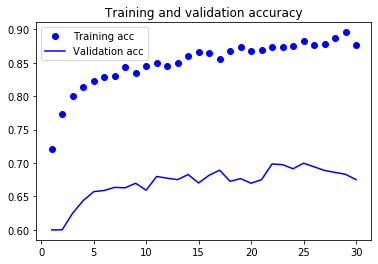

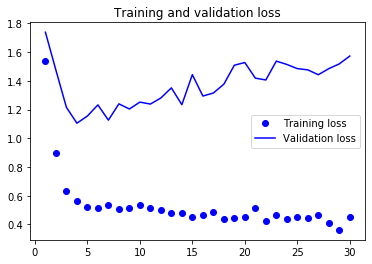

In [0]:
# plot the graph base on history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# save the plot's image
temp_plot_image_name = 'yo_plot_' + time_stamp + '.png'
drive_plot_image_name = os.path.join(HISTORY_DIR, temp_plot_image_name)
plt.savefig(drive_plot_image_name)

<Figure size 432x288 with 0 Axes>

# Predictions

In [0]:
# load the model with the best weights here
model.load_weights(drive_hdf5_fname)

In [0]:
# obtain the predictions here
predictions = model.predict(test_x)
confusion_matrix(np.argmax(test_y, axis=1), np.argmax(predictions, axis=1))

array([[528, 144],
       [ 98, 607]])

# Evaluating the result

In [0]:
print(classification_report( np.argmax(test_y, axis=1), np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       672
           1       0.81      0.86      0.83       705

    accuracy                           0.82      1377
   macro avg       0.83      0.82      0.82      1377
weighted avg       0.83      0.82      0.82      1377



# Fine tuning

In [0]:
# Unfreeze the last few layers
conv_base.trainable = True
set_trainable = False
num_unfreeze_layer = 0
num_freeze_layer = 0

for layer in conv_base.layers:
  if layer.name == FREEZE_LAYER:
    set_trainable = True
  if set_trainable:
    layer.trainable = True
    num_unfreeze_layer += 1
  else:
    print(layer.name)
    layer.trainable = False
    num_freeze_layer += 1
print("num_unfreeze_layer =", num_unfreeze_layer)
print("num_freeze_layer =", num_freeze_layer)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
num_unfreeze_layer = 4
num_freeze_layer = 15


In [0]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [0]:
# train the model
equal_str = 'equal' if IS_MALIGNANT_AND_BENIGN_SAME_SIZE else 'unequal'
local_hdf5_finetune_fname = 'yo_model_hdf5_{}_{}_{}_finetune.hdf5'.format(
                                      TARGET_WIDTH, equal_str, time_stamp)
print("local_hdf5_fname =", local_hdf5_finetune_fname)

learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                verbose=1,factor=0.2, min_lr=1e-7)

checkpoint = ModelCheckpoint(local_hdf5_finetune_fname, monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')

print("starting to train the model at", timer.elapsed())
history = model.fit_generator(
    train_generator,
    steps_per_epoch=(len(train_x) // TRAIN_BATCH_SIZE),
    epochs=TRAIN_EPOCHS,
    validation_data=validation_generator,
    validation_steps=(len(val_x) // VALIDATION_BATCH_SIZE),
    callbacks=[learn_control, checkpoint]
)
print("done training the model at", timer.elapsed())
print("time for training two models =", timer.elapsed())

local_hdf5_fname = yo_model_hdf5_300_equal_20191114_000328_finetune.hdf5
starting to train the model at 29 minutes 47 seconds
Epoch 1/30
332/332 [==============================] - 59s 177ms/step - loss: 0.4466 - acc: 0.8255 - val_loss: 0.8809 - val_acc: 0.6893

Epoch 00001: val_acc improved from -inf to 0.68930, saving model to yo_model_hdf5_300_equal_20191114_000328_finetune.hdf5
Epoch 2/30
332/332 [==============================] - 60s 181ms/step - loss: 0.3442 - acc: 0.8682 - val_loss: 0.7603 - val_acc: 0.6906

Epoch 00002: val_acc improved from 0.68930 to 0.69061, saving model to yo_model_hdf5_300_equal_20191114_000328_finetune.hdf5
Epoch 3/30
332/332 [==============================] - 61s 183ms/step - loss: 0.2609 - acc: 0.8999 - val_loss: 1.1831 - val_acc: 0.7542

Epoch 00003: val_acc improved from 0.69061 to 0.75415, saving model to yo_model_hdf5_300_equal_20191114_000328_finetune.hdf5
Epoch 4/30
332/332 [==============================] - 59s 179ms/step - loss: 0.2384 - acc: 0.9

# Save all the related values into google drive (fine-tuning)

In [0]:
# save the history to plot the graph later on
print("starting to save at", timer.elapsed())
equal_str = 'equal' if IS_MALIGNANT_AND_BENIGN_SAME_SIZE else 'unequal'
print("time_stamp = ", time_stamp)
temp_history_fname = 'yo_history_{}_{}_{}_finetune.json'.format(TARGET_WIDTH, 
                                                                equal_str,
                                                                time_stamp)
drive_history_finetune_fname = os.path.join(HISTORY_DIR, temp_history_fname)
with open(drive_history_finetune_fname, 'w') as f:
  json.dump(str(history.history), f)
print("done saving to {}".format(drive_history_finetune_fname))

# save the model with all its weight and structure
local_model_finetune_filename = 'yo_model_{}_{}_{}_finetune.h5'.format(
                                          TARGET_WIDTH, equal_str, time_stamp)
drive_model_finetune_filename = os.path.join(HISTORY_DIR, 
                                             local_model_finetune_filename)
model.save(local_model_finetune_filename)
model.save(drive_model_finetune_filename)
print("done saving to", drive_model_finetune_filename)

drive_hdf5_finetune_fname = os.path.join(HISTORY_DIR, local_hdf5_finetune_fname)
import shutil
shutil.copyfile(local_hdf5_finetune_fname, drive_hdf5_finetune_fname)
print("done saving at", timer.elapsed())

starting to save at 59 minutes 45 seconds
time_stamp =  20191114_000328
done saving to /mntDrive/My Drive/ML Project/final_code/saved/20191114_000328/yo_history_300_equal_20191114_000328_finetune.json
done saving to /mntDrive/My Drive/ML Project/final_code/saved/20191114_000328/yo_model_300_equal_20191114_000328_finetune.h5
done saving at 59 minutes 47 seconds


  # Loading the model from directory (fine-tuning)

In [0]:
if LOAD_WEIGHT_FROM_DIRECTORY:
  print("Loading model from {} \n\tat {}".format(drive_hdf5_finetune_fname, 
                                             timer.elapsed()))
  # drive_hdf5_finetune_fname stores the best results
  model.load_weights(drive_hdf5_finetune_fname)

Loading model from /mntDrive/My Drive/ML Project/final_code/saved/20191114_000328/yo_model_hdf5_300_equal_20191114_000328_finetune.hdf5 
	at 59 minutes 47 seconds


# Plotting the graphs

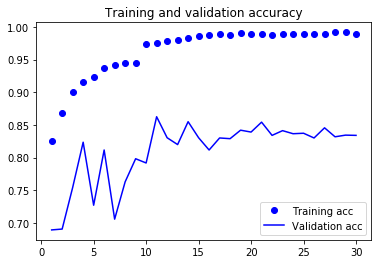

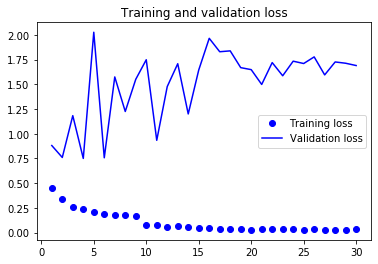

In [0]:
# plot the graph base on history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
# save the plot's image
temp_plot_image_name = 'yo_plot_' + time_stamp + '.png'
drive_plot_image_name = os.path.join(HISTORY_DIR, temp_plot_image_name)
plt.savefig(drive_plot_image_name)

<Figure size 432x288 with 0 Axes>

# Predictions

In [0]:
# obtain the predictions here
predictions = model.predict(test_x)
confusion_matrix(np.argmax(test_y, axis=1), np.argmax(predictions, axis=1))

array([[568, 104],
       [ 52, 653]])

# Evaluating the result

In [0]:
print(classification_report( np.argmax(test_y, axis=1), np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       672
           1       0.86      0.93      0.89       705

    accuracy                           0.89      1377
   macro avg       0.89      0.89      0.89      1377
weighted avg       0.89      0.89      0.89      1377



In [0]:
print("all done in", timer.elapsed())
print("time since the start of the first model training", model_timer.elapsed())

all done in 59 minutes 55 seconds
time since the start of the first model training 58 minutes 44 seconds


In [0]:
print("num_unfreeze_layer =", num_unfreeze_layer)
print("num_freeze_layer =", num_freeze_layer)

num_unfreeze_layer = 4
num_freeze_layer = 15
